# Predicting Arrival Times for Denver airport using Random Forests and Naive Bayes

The data is of 2008 for Flight arrival times for Denver airport. We will use this data to predict arrival times for planes in order to help a potential passenger figure out which flight to book so that they can avoid getting delayed.

In [1]:
import os
import pandas as pd
import datetime as datetime
import numpy as np
import seaborn as sns; sns.set(); sns.set(font_scale=1.3)
import matplotlib.pyplot as plt

# Random Forest Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import RandomizedSearchCV #For hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier

# Model Performance Measurement libraries
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#Naive Bayes Libraries
from sklearn.naive_bayes import GaussianNB

# Seed for reproducibility
SEED = 1

In [2]:
# Read the csv file using pandas
den = pd.read_csv('2008_data.csv')
den.shape[0]

299999

In [3]:
# to view all columns in the dataframe
pd.set_option('display.max_columns', 500)

In [4]:
# Looking at a few rows to understand the data
den.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,N612SW,88.0,90,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [5]:
# We can see so many record with NaN values 
# define the datatypes of each column
den.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode      object
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object

[Text(0, 0.5, 'Density of Probability'), Text(0.5, 0, 'ArrDelay value')]

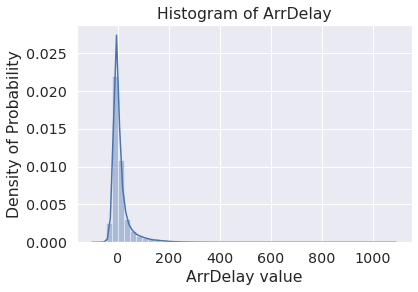

In [6]:
# Finding the Distribution of the Dependent variable "ArrDelay" which we will be using later in this Notebook 
# as part of our Classification model.
ax = sns.distplot(den['ArrDelay'].dropna(axis = 0));
ax.set_title('Histogram of ArrDelay')
ax.set(xlabel='ArrDelay value', ylabel='Density of Probability')

In [7]:
# taking care of NaN
# Number of records with NaN
den[den.ArrDelay.isna()].shape[0]
# Alternative way to view unique values and counts 
# den.ArrDelay.value_counts(dropna=False)

8924

*These 8924 records are not useful records and should be removed. It cannot be replaced with 0s and hence cannot be used in prediction in our model or for testing the model.*

In [8]:
# Removing the records having null value in ArrDelay column
den = den[den.ArrDelay.notnull()]
den.shape

(291075, 29)

In [9]:
# Fill null values with 0
den = den.fillna(0)

In [10]:
# Convert the time columns present in the dataset as hmm.0 or hhmm.0 to HH:MM:SS format - The Actual change
def getTime(t):
    if len(t) == 4:    # When the number has 4 digits
        if t == "2400": # Convert 24 O'Clock to 0 O'Clock which is midnight
            t = "0000"
            
        t = t + '00' # Add seconds as '00' so that we have a 6 digit string
        return t[:2] + ':' + t[2:4] + ':' + t[4:] # Split the 6 digit number to the format 12:34:45
    elif len(t) == 3: # When the number has 3 digits
        # Add 0 to begining of the string to convert 0 to 9 hours as 00 to 09 hours 
        # Add seconds as '00' so that we have a 6 digit string
        t = '0' + t + '00' 
        return t[:2] + ':' + t[2:4] + ':' + t[4:] # Split the 6 digit number to the format 12:34:45

In [11]:
# Convert the time columns present in the dataset as hmm.0 or hhmm.0 to HH:MM:SS format - Preprocessing work to be done on the selected columns
def transform_time_column(data,column):
    # Convert float to string object
    data[column] = data[column].apply(lambda x: str(x) if not pd.isnull(x) else x)
    # Retain only whole number
    data[column] = data[column].str.replace('\.0','')
    # Convert the whole number to HH:MM:SS
    data[column] = data[column].map(getTime, na_action='ignore')
    # Convert the column to timedelta64[ns] data type
    data[column] = pd.to_timedelta(data[column],'T')

In [12]:
# Using the above function, transforming the time columns into their correct format
transform_time_column(den,'DepTime')
transform_time_column(den,'CRSDepTime')
transform_time_column(den,'ArrTime')
transform_time_column(den,'CRSArrTime')
den.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,20:03:00,19:55:00,22:11:00,22:25:00,WN,335,N712SW,128.0,150,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,2008,1,3,4,07:54:00,07:35:00,10:02:00,10:00:00,WN,3231,N772SW,128.0,145,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,2008,1,3,4,06:28:00,06:20:00,08:04:00,07:50:00,WN,448,N428WN,96.0,90,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,2008,1,3,4,09:26:00,09:30:00,10:54:00,11:00:00,WN,1746,N612SW,88.0,90,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,2008,1,3,4,18:29:00,17:55:00,19:59:00,19:25:00,WN,3920,N464WN,90.0,90,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,0,0,2.0,0.0,0.0,0.0,32.0


In [13]:
# Check the datatype and null entry in the dataset
den.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291075 entries, 0 to 299998
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   Year               291075 non-null  int64          
 1   Month              291075 non-null  int64          
 2   DayofMonth         291075 non-null  int64          
 3   DayOfWeek          291075 non-null  int64          
 4   DepTime            290556 non-null  timedelta64[ns]
 5   CRSDepTime         291075 non-null  timedelta64[ns]
 6   ArrTime            287296 non-null  timedelta64[ns]
 7   CRSArrTime         288779 non-null  timedelta64[ns]
 8   UniqueCarrier      291075 non-null  object         
 9   FlightNum          291075 non-null  int64          
 10  TailNum            291075 non-null  object         
 11  ActualElapsedTime  291075 non-null  float64        
 12  CRSElapsedTime     291075 non-null  int64          
 13  AirTime            291075 non

### Input independent variables and output dependent variable

`Variable descriptions
Name Description
1 Year 1987-2008
2 Month 1-12
3 DayofMonth 1-31
4 DayOfWeek 1 (Monday) - 7 (Sunday)
5 DepTime actual departure time (local, hhmm)
6 CRSDepTime scheduled departure time (local, hhmm)
7 ArrTime actual arrival time (local, hhmm)
8 CRSArrTime scheduled arrival time (local, hhmm)
9 UniqueCarrier unique carrier code
10 FlightNum flight number
11 TailNum plane tail number
12 ActualElapsedTime in minutes
13 CRSElapsedTime in minutes
14 AirTime in minutes
15 ArrDelay arrival delay, in minutes
16 DepDelay departure delay, in minutes
17 Origin origin IATA airport code
18 Dest destination IATA airport code
19 Distance in miles
20 TaxiIn taxi in time, in minutes
21 TaxiOut taxi out time in minutes
22 Cancelled was the flight cancelled?
23 CancellationCode reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24 Diverted 1 = yes, 0 = no
25 CarrierDelay in minutes
26 WeatherDelay in minutes
27 NASDelay in minutes
28 SecurityDelay in minutes
29 LateAircraftDelay in minutes`

In [14]:
# Calculating Total Delays by summing up all the Delay Columns
den['total_delays'] = den['ArrDelay'] + den['DepDelay'] + den['CarrierDelay'] + den['WeatherDelay'] + den['NASDelay'] + den['SecurityDelay'] + den['LateAircraftDelay']
# Finding the mean of total delays for each day of the week
den.groupby(["DayOfWeek"]).agg({'total_delays': [np.mean]})

,total_delays
,mean
DayOfWeek,
1,41.851920
2,36.113787
3,25.769113
4,48.822087
5,38.077967
6,27.708723
7,40.871012


*We are interested in Arrival delays. Hence finding mean arrival delays for each day of the week*

In [15]:
# Finding the mean of Arrival delays for each day of the week
mean_week_arr = den.groupby(["DayOfWeek"], as_index=False).agg({'ArrDelay': [np.mean]})
# Dropping the unnecessary column header created by the agg function above
mean_week_arr.columns = mean_week_arr.columns.droplevel(1)
mean_week_arr

,DayOfWeek,ArrDelay
0,1,11.898271
1,2,10.048745
2,3,6.061316
3,4,15.098165
4,5,10.895985
5,6,6.230296
6,7,11.320227


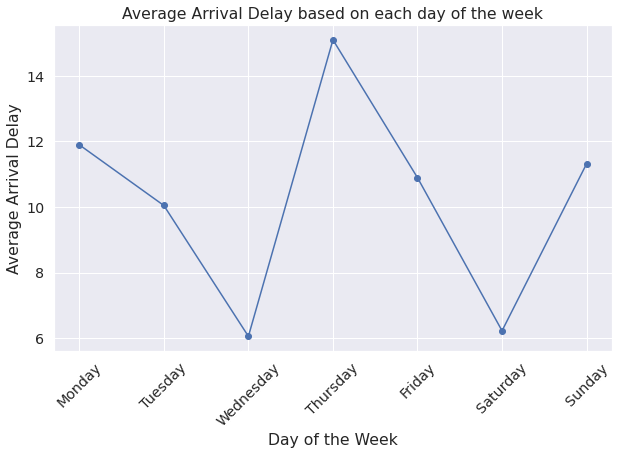

In [16]:
fig = plt.figure(figsize=(10,6))
# Plotting the Average ArrDelay values as y-axis and Day of the week as x-axis and connecting them with a line in the graph.
plt.plot('DayOfWeek', 'ArrDelay', data=mean_week_arr, linestyle='-', marker='o')
plt.title('Average Arrival Delay based on each day of the week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Arrival Delay')
# Changing the x-axis values from 1,2,.. to Monday, Tuesday,..
plt.xticks((1,2,3,4,5,6,7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'), rotation=45)
plt.show()

`Delay seems to be the highest during Thursdays followed by Mondays and Sundays.`

In [17]:
# Finding number of flights on each day of the week
flight_week_count = den.groupby(["DayOfWeek"], as_index=False).size().to_frame(name = 'NumberOfFlights').reset_index()
flight_week_count

,DayOfWeek,NumberOfFlights
0,1,39222
1,2,46877
2,3,47508
3,4,48816
4,5,40004
5,6,31846
6,7,36802


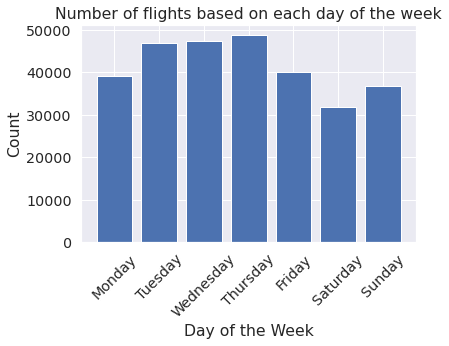

In [18]:
# Plotting the Number of flights on each day of the week
plt.bar(flight_week_count.DayOfWeek,flight_week_count.NumberOfFlights)
# Changing the x-axis values from 1,2,.. to Monday, Tuesday,..
plt.xticks((1,2,3,4,5,6,7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'), rotation=45)
plt.title('Number of flights based on each day of the week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.show()

*It is understandable that the Arrival Delays is more on Thursday since it has the maximum number of flights fly on that day. But Suprisingly inspite of the large number of flights, Arrival Delay seems to be less on Wednesdays.*

`In my case, the delay seems to be on Wednesdays and Saturdays.`

## Exploratory Data Analysis

In [19]:
# Understanding the datatypes of all the variables in the dataset
den.dtypes

Year                           int64
Month                          int64
DayofMonth                     int64
DayOfWeek                      int64
DepTime              timedelta64[ns]
CRSDepTime           timedelta64[ns]
ArrTime              timedelta64[ns]
CRSArrTime           timedelta64[ns]
UniqueCarrier                 object
FlightNum                      int64
TailNum                       object
ActualElapsedTime            float64
CRSElapsedTime                 int64
AirTime                      float64
ArrDelay                     float64
DepDelay                     float64
Origin                        object
Dest                          object
Distance                       int64
TaxiIn                       float64
TaxiOut                      float64
Cancelled                      int64
CancellationCode               int64
Diverted                       int64
CarrierDelay                 float64
WeatherDelay                 float64
NASDelay                     float64
S

In [20]:
# Changing the necessary variables as Categorical Variables.
den["Cancelled"] = den["Cancelled"].astype('category')
den["Diverted"] = den["Diverted"].astype('category')
den["UniqueCarrier"] = den["UniqueCarrier"].astype('category')

In [21]:
# Checking the summary statistics of Categorical/Object variables
den.select_dtypes(exclude='number').describe()

,UniqueCarrier,TailNum,Origin,Dest,Cancelled,Diverted
count,291075,291075,291075,291075,291075,291075
unique,7,2103,217,216,1,1
top,WN,N693BR,PHX,PHX,0,0
freq,97375,359,14928,14925,291075,291075


In [22]:
# Retaining only the variables we are interested to use in our model
den = den[['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'UniqueCarrier', 
           'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
           'SecurityDelay', 'LateAircraftDelay', 'ArrDelay']]
display(pd.DataFrame(den.describe()))

,Year,Month,DayofMonth,DayOfWeek,ActualElapsedTime,CRSElapsedTime,AirTime,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelay
count,291075.0,291075.0,291075.000000,291075.000000,291075.000000,291075.000000,291075.000000,291075.000000,291075.000000,291075.000000,291075.000000,291075.000000,291075.000000,291075.000000,291075.000000,291075.000000,291075.000000
mean,2008.0,1.0,16.095364,3.845998,117.942877,119.945100,96.153153,12.355644,653.442845,6.046507,15.743217,3.893364,0.792473,3.808524,0.027677,6.050623,10.353421
std,0.0,0.0,8.885958,1.925986,64.342300,64.798113,62.270278,36.258600,513.689693,4.364426,10.383672,18.932330,9.857359,18.525641,0.947920,23.247397,39.726286
min,2008.0,1.0,1.000000,1.000000,16.000000,18.000000,0.000000,-92.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-91.000000
25%,2008.0,1.0,8.000000,2.000000,73.000000,75.000000,53.000000,-4.000000,308.000000,4.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000
50%,2008.0,1.0,16.000000,4.000000,100.000000,101.000000,78.000000,0.000000,495.000000,5.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
75%,2008.0,1.0,24.000000,5.000000,143.000000,145.000000,119.000000,11.000000,843.000000,7.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000
max,2008.0,1.0,31.000000,7.000000,571.000000,556.000000,535.000000,1099.000000,4243.000000,213.000000,221.000000,1032.000000,587.000000,569.000000,136.000000,799.000000,1081.000000


*Year, Month are constants with values at 2008 and 1 respectively. They don't add value to our model and can be removed.
We can decide if we want to use ActualElapsedTime, CRSElapsedTime and AirTime based on the correlation we observe after removing outliers.
The differnt delays have outliers. We need not remove them but we can just observe the number of records retained which will help us to see if Linear Regression model can be run in this data.*

In [23]:
df = den[['DayofMonth', 'DayOfWeek', 'AirTime', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay',
          'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'ArrDelay']]
# Finding the quantile values for all the variables in the model
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Removing the outliers
df = df[((df >= (Q1 - 1.5 * IQR)) & (df <= (Q3 + 1.5 * IQR))).all(axis=1)]
display(pd.DataFrame(df.describe()))

,DayofMonth,DayOfWeek,AirTime,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelay
count,188158.000000,188158.000000,188158.000000,188158.000000,188158.000000,188158.000000,188158.000000,188158.0,188158.0,188158.0,188158.0,188158.0,188158.000000
mean,16.220320,3.827916,81.629195,-0.592816,540.341686,5.097179,13.376864,0.0,0.0,0.0,0.0,0.0,-5.697648
std,8.628366,1.925811,40.010270,6.901109,327.462175,2.131036,5.956393,0.0,0.0,0.0,0.0,0.0,10.014704
min,1.000000,1.000000,9.000000,-26.000000,36.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-47.000000
25%,9.000000,2.000000,51.000000,-5.000000,293.000000,4.000000,9.000000,0.0,0.0,0.0,0.0,0.0,-12.000000
50%,16.000000,4.000000,71.000000,-2.000000,448.000000,5.000000,12.000000,0.0,0.0,0.0,0.0,0.0,-5.000000
75%,24.000000,5.000000,106.000000,1.000000,737.000000,6.000000,16.000000,0.0,0.0,0.0,0.0,0.0,1.000000
max,31.000000,7.000000,218.000000,33.000000,1642.000000,11.000000,34.000000,0.0,0.0,0.0,0.0,0.0,14.000000


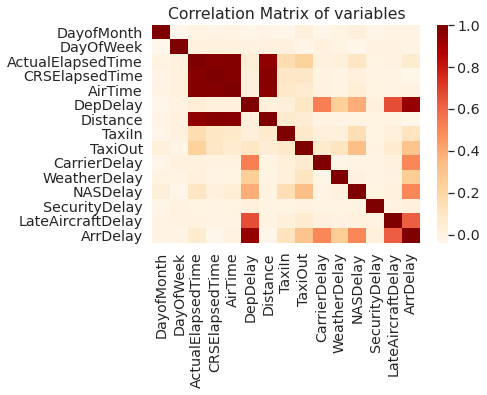

In [24]:
# Find correlation matrix 
corr_table = den[['DayofMonth', 'DayOfWeek', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'DepDelay', 
                  'Distance', 'UniqueCarrier', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted', 'CarrierDelay', 'WeatherDelay',
                  'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'ArrDelay']].corr()
ax = sns.heatmap(corr_table, 
            xticklabels=corr_table.columns,
            yticklabels=corr_table.columns,
            cmap="OrRd")
ax.set_title('Correlation Matrix of variables')
plt.show()

`There seems to be a very high correlation between the ActualElapsedTime, CRSElapsedTime, AirTime and Distance. Hence choosing only Distance as the independent variable among the above 4 variables. A strong correlation exists between DepDelay and ArrDelay. We can try removing and having DepDelay as independent variable in two different models.`

In [25]:
# Choosing necessary variables for X & y of our model
y = den['ArrDelay'].values
X = den[['DayofMonth', 'DayOfWeek', 'DepDelay', 'Distance', 'UniqueCarrier', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted', 
         'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']]

Since we are planning to have 'UniqueCarrier' we are using once hot encoding as RandomForestRegressor and RandomForestClassifier cannot handle multi-category explonatory variables.

In [26]:
# Finding the number of flights for each carrier
den.UniqueCarrier.value_counts(dropna=False)

WN    97375
OO    46247
US    38513
UA    36486
XE    34368
YV    20666
OH    17420
Name: UniqueCarrier, dtype: int64

In [27]:
# Implementing One-Hot Encoding
X=pd.get_dummies(X, prefix=['UniqueCarrier'], columns=['UniqueCarrier'])
X.head()

,DayofMonth,DayOfWeek,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
0,3,4,8.0,810,4.0,8.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0
1,3,4,19.0,810,5.0,10.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0
2,3,4,8.0,515,3.0,17.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0
3,3,4,-4.0,515,3.0,7.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0
4,3,4,34.0,515,3.0,10.0,0,0,2.0,0.0,0.0,0.0,32.0,0,0,0,0,1,0,0


In [28]:
pd.DataFrame(X).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291075 entries, 0 to 299998
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   DayofMonth         291075 non-null  int64   
 1   DayOfWeek          291075 non-null  int64   
 2   DepDelay           291075 non-null  float64 
 3   Distance           291075 non-null  int64   
 4   TaxiIn             291075 non-null  float64 
 5   TaxiOut            291075 non-null  float64 
 6   Cancelled          291075 non-null  category
 7   Diverted           291075 non-null  category
 8   CarrierDelay       291075 non-null  float64 
 9   WeatherDelay       291075 non-null  float64 
 10  NASDelay           291075 non-null  float64 
 11  SecurityDelay      291075 non-null  float64 
 12  LateAircraftDelay  291075 non-null  float64 
 13  UniqueCarrier_OH   291075 non-null  uint8   
 14  UniqueCarrier_OO   291075 non-null  uint8   
 15  UniqueCarrier_UA   291075 non-null

*There is a new variable created for each of the 7 categories of UniqueCarrier. But using them all in the model will create multi collinearity. Hence we will remove one of the UniqueCarrier variable from our model as a regressor. Let's drop variable "UniqueCarrier_YV". We still won't lose any information, since if all the other 6 UniqueCarrier are 0, it means the UniqueCarrier of that record is YV.*

In [29]:
X.drop(columns='UniqueCarrier_YV', inplace=True)

In [30]:
# Split dataset into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

## Random Forest

In [31]:
def random_forest_regressor(Training_X, Test_X, n_estimators=10, min_samples_leaf=1): #passing default values of parameters of they aren't passed during call
    # Instantiate a random forests regressor
    rf = RandomForestRegressor(random_state=SEED, n_estimators=n_estimators,  min_samples_leaf=min_samples_leaf)
    # Fit 'rf' to the training set
    rf.fit(Training_X, y_train)
    # Predict the test set labels 'y_pred'
    y_pred = rf.predict(Test_X)
    # Evaluate the test set RMSE
    rmse_test = MSE(y_test, y_pred)**(1/2)
    # Print the test set RMSE
    print('Test set RMSE of Random Forest with n_estimators=',n_estimators,'and  min_samples_leaf=',min_samples_leaf,': {:.2f}'.format(rmse_test))
    # Create a pd.Series of features importances and sort it
    importances_rf = pd.Series(data=rf.feature_importances_, index = Training_X.columns)
    importances_rf = importances_rf.sort_values(ascending=False)
    # Make a horizontal bar plot
    draw_importance_bar(importances_rf)

In [32]:
# Function to draw graph of important variables
def draw_importance_bar(importances_features):
    fig = plt.figure(figsize=(10,6))
    ax = importances_features.sort_values(ascending=True).plot.barh(color='red'
                                                                    , title='Plot of Important Variables in the Random Forest')
    for rect in ax.patches:
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2
        plt.annotate("{:.3f}".format(x_value), #Display 3 decimal digits of the value
                     (x_value,y_value), # Place label at end of the bar
                     xytext=(5, 0), # Horizontally shift label
                     textcoords="offset points", # Interpret `xytext` as offset in points
                     va='center') # Vertically center label
    plt.show()

Test set RMSE of Random Forest with n_estimators= 10 and  min_samples_leaf= 1 : 7.70


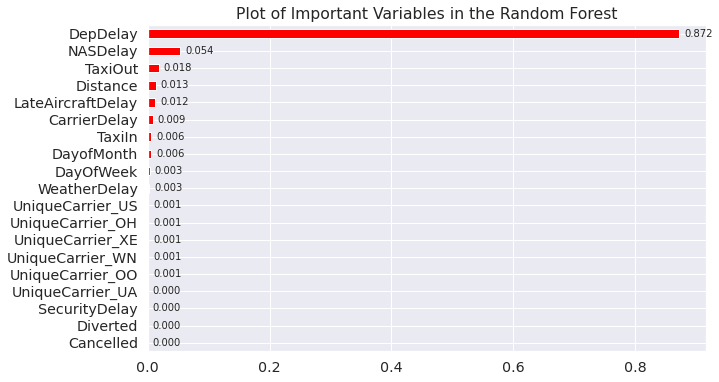

In [33]:
# Running the random forests regressor with Default Parameters
rf1 = random_forest_regressor(X_train, X_test)

Test set RMSE of Random Forest with n_estimators= 300 and  min_samples_leaf= 0.1 : 27.30


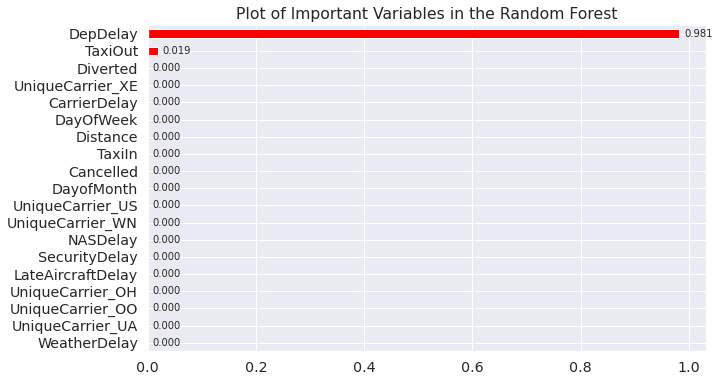

CPU times: user 42.6 s, sys: 44.3 ms, total: 42.7 s
Wall time: 42.7 s


In [34]:
%%time
rf2 = random_forest_regressor(X_train, X_test, n_estimators=300, min_samples_leaf=0.10)

Test set RMSE of Random Forest with n_estimators= 10 and  min_samples_leaf= 1 : 9.40


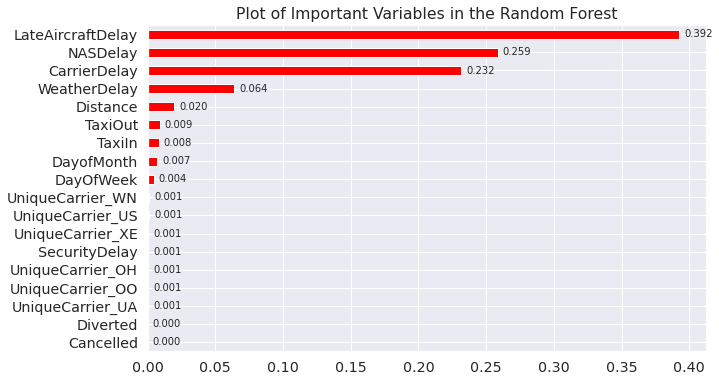

In [35]:
rf3 = random_forest_regressor(X_train.loc[:, X_train.columns != 'DepDelay'],X_test.loc[:, X_test.columns != 'DepDelay'])

The base model performs better than the set parameters. Hence we have to find the optimum parameters of our Random Forest model. Hence we need to perform hyperparameter tuning.

## Random Forest Hyper Parameter Tuning

The following are the Random Forest Paramters that we care going to experiment with to find the best Parameters
* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)
Our parameters
* n_estimators = [100, 200, 300, 400, 500] = 5 possile values
* max_features = ['auto', 'sqrt'] = 2 possile values
* max_depth = [None, 5, 10, 15, 20, 25] = 5 possile values
* min_samples_split = [2, 5, 10] = 3 possile values
* min_samples_leaf = [1, 2, 4] = 3 possile values
* bootstrap = [True, False] = 2 possile values
Prefering RandomizedSearchCV over GridSearchCV
* Total Possible Number of Combinations = 5 * 2 * 5 * 3 * 3 * 2 = 900 possible parameter combinations we can do.
* 'GridSearchCV' from sklearn.model_selection library can find the best parameters from the 900 possible combinations but it will be time consuming.
Hence using 'RandomizedSearchCV' from the same library to find the best parameters from the 60 random combinations selected out of the possible 900 combinations.

In [36]:
# Number of trees in random forest #Creates this array : [100, 200, 300, 400, 500]
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)] 
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree : Creates this array : [5, 10, 15, 20, 25]
max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]
max_depth.append(None) #Add none to the array
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [37]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

In [38]:
# Random search of parameters, using 3 fold cross validation, 
# search across 60 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=SEED, n_jobs = 8)

In [40]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  6.1min
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed: 16.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [41]:
# Finding the best combination of parameters from the 60 combinations generated above
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [42]:
# Function to predict performance of the Random Forest model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))

In [43]:
# Finding performance of the Random Forest Regressor model
evaluate(rf_random, X_test, y_test)

Model Performance
Average Error: 4.7638 degrees.


In [44]:
# Finding the best estimators of our RF Regressor model
best_random = rf_random.best_estimator_
best_random

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

`To consider doing both Random Forest and Naive Bayes, we can bin the target variable 'ArrDelay' into bins to make it as a Classification problem. We are doing this since Naive Bayes only helps in classification.`

## Random Forest Classifier

We can categorize ArrDelay into the following categories:

* Less than -30 : Very Early
* Less than 0 & Greater than or equal to -30 : Early
* 0 to 5 : Ontime
* 5 to 30 : Late
* Greater than 30 : Very late

In [45]:
bins = [-100, -30, 0, 5, 30, 1200]
labels = ["Very Early", "Early", "Ontime", "Late", "Very Late"]
# labels = [1,2,3,4,5]
den['ArrDelay_category'] = pd.cut(den['ArrDelay'], bins=bins, labels=labels)

In [46]:
den['ArrDelay_category'].describe()

count     291075
unique         5
top        Early
freq      150586
Name: ArrDelay_category, dtype: object

In [47]:
# define y variable
y = den['ArrDelay_category']
y.dtype

CategoricalDtype(categories=['Very Early', 'Early', 'Ontime', 'Late', 'Very Late'], ordered=True)

In [48]:
# Convering the y variable into object datatype so that we don't run into error while fitting the model
y = y.astype('object')
y.dtype

dtype('O')

In [49]:
# Finding the counts of records in each category of ArrDelay
y.value_counts(dropna=False)

Early         150586
Late           62967
Very Late      43943
Ontime         29426
Very Early      4153
Name: ArrDelay_category, dtype: int64

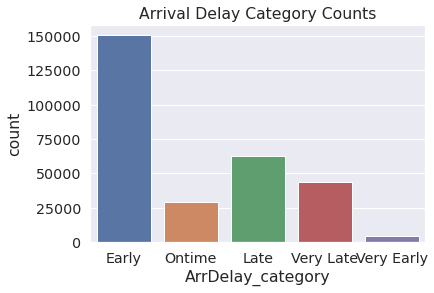

In [50]:
# Plotting the counts of records in each category of ArrDelay
ax = sns.countplot(y)
ax.set_title('Arrival Delay Category Counts')
plt.show()

In [51]:
# Split dataset into 70% train and 30% test. Doing this again since we have a new categorical y.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [52]:
# Initiate the RandomForestClassifier
rf = RandomForestClassifier()

In [53]:
# Using RandomizedSearchCV to find the best parameters of RandomForestClassifier
rf_classify = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=SEED, n_jobs = -1)

In [54]:
# Training the RandomForestClassifier model with the best parameters
rf_classify.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  60 | elapsed:  1.3min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done  43 out of  60 | elapsed:  2.3min remaining:   55.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [55]:
rf_classify.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

*We can observe that the best parameters of both the Random Forest Classifier and Random Forest Regressor are the same. They have the same X variables but different y variable. For Classifier the target variable is binned while for the Regressor, the target variable is continous.*

In [56]:
rf_classify.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [57]:
# Predicting the ArrDelayCategory for our Test data
y_pred = rf_classify.predict(X_test)

In [58]:
# Evaluating the performance of Test data using Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[43461,  1518,   182,     0,     0],
       [ 4806, 13759,   242,     1,    60],
       [ 6650,  1879,   294,     0,     0],
       [ 1229,    13,     0,     3,     0],
       [    0,   175,     0,     0, 13051]])

In [59]:
# Listing the Precision, Recall and other metrics for each of the category
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Early       0.77      0.96      0.86     45161
        Late       0.79      0.73      0.76     18868
      Ontime       0.41      0.03      0.06      8823
  Very Early       0.75      0.00      0.00      1245
   Very Late       1.00      0.99      0.99     13226

    accuracy                           0.81     87323
   macro avg       0.74      0.54      0.54     87323
weighted avg       0.77      0.81      0.76     87323



[Text(85.18, 0.5, 'Actual'), Text(0.5, 8.5, 'Predicted')]

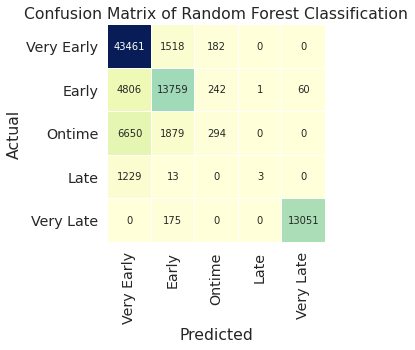

In [60]:
# Plotting the Confusion Matrix for understanding
ax = plt.axes()
sns.heatmap(cm, 
            annot=True, # Show values of each cell in the heatmap
            fmt="1.0f", # or "d for int"
            cmap="YlGnBu", # color range of the heatmap
            linecolor='white', # plot cell border
            linewidths=0.1, # width of border
            cbar=False, # hide range bar
            xticklabels=["Very Early", "Early", "Ontime", "Late", "Very Late"], # Change X and Y axis values
            yticklabels=["Very Early", "Early", "Ontime", "Late", "Very Late"],
            square=True) # Make the Confusion Matrix Look like a square
ax.set_title('Confusion Matrix of Random Forest Classification')
ax.set(xlabel='Predicted', ylabel='Actual') # Change X and Y axis labels

`The model performs well predicting 'Very Early' and 'Very Late' flights. However the Precision is poor for Ontime flights.`

In [61]:
# Finding the accuracy of the Random Forest Classifier Model
accuracy_score(y_test, y_pred)

0.808126152331001

## Naive bayes classifier

In [62]:
# Initiate a Naive Bayes Model
model = GaussianNB()
# Train the model with the Training data
model.fit(X_train, y_train);

In [63]:
# Make predictions by running the Naive Bayes Model on the explanatory variables of our test data
y_pred = model.predict(X_test)

In [64]:
# Evaluating the performance of Test data using Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[39502,     0,  2135,  3520,     4],
       [ 5039,  8290,  4532,   598,   409],
       [ 6592,     0,  1634,   596,     1],
       [  839,     0,    22,   384,     0],
       [    0,  2111,     0,     0, 11115]])

In [65]:
# Listing the Precision, Recall and other metrics for each of the category
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Early       0.76      0.87      0.81     45161
        Late       0.80      0.44      0.57     18868
      Ontime       0.20      0.19      0.19      8823
  Very Early       0.08      0.31      0.12      1245
   Very Late       0.96      0.84      0.90     13226

    accuracy                           0.70     87323
   macro avg       0.56      0.53      0.52     87323
weighted avg       0.73      0.70      0.70     87323



[Text(85.18, 0.5, 'Actual'), Text(0.5, 8.5, 'Predicted')]

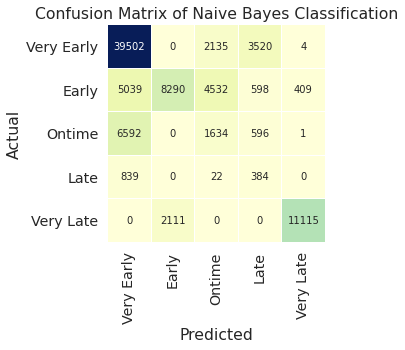

In [66]:
# Plot confusion matrix
ax = plt.axes()
sns.heatmap(cm, 
            annot=True, # Show values of each cell in the heatmap
            fmt="1.0f", # or "d"
            cmap="YlGnBu", # color range of the heatmap
            linecolor='white', # plot cell border
            linewidths=0.1, # width of border
            cbar=False, # hide range bar
            xticklabels=["Very Early", "Early", "Ontime", "Late", "Very Late"], # Change X and Y axis values
            yticklabels=["Very Early", "Early", "Ontime", "Late", "Very Late"],
            square=True) # Make the Confusion Matrix Look like a square
ax.set_title('Confusion Matrix of Naive Bayes Classification')
ax.set(xlabel='Predicted', ylabel='Actual') # Change X and Y axis labels

`The model performs well predicting 'Very Early' and 'Very Late' flights. However the Precision is poor for other flights. The prediction is worse than our Random Forest Classification.`

In [67]:
# Finding the accuracy of the Random Forest Classifier Model
accuracy_score(y_test, y_pred)

0.6976970557585058

## Conclusion

`The accuracy of our Random Forest Classification is 81% while our Naive Bayes Classification is only 70%. We were able to generate the best Random Forest Classifier by hyperparameter tuning. However we did could not do hyperparameter tuning on the Naive Bayes classifier as it is so naive that it doesn't accept parameters except priors which we don't know. Hence Random Forest is a better Classification model for this dataset.`